# Adatbányászat gyakorlat 5.
***
Időpont: péntek, 8\:30–10\:00 és 10\:15–11\:45<br/>
Helyszín: 3-107 / 3-111<br/>
Elérhetőségek: TEAMS chat, csoport

## Követelmények
***
### Röpzh
Minden óra végén fel lesz adva néhány egyszerű, lényegretörő kérdés az adott óra anyagából.

#### Értékelés
Minden feladat **1 pontot** ér a végső elszámolásban. Röpzh-kból összesen **10 pont** szerezhető majd.

### Házi feladat
A házi feladatok elkészítésére mindig **3 hetetek** lesz, beküldés után pedig még van lehetőség javítani a visszaküldött feladatokon. Az első változatot azonban a feladástól számított **két héten belül** várjuk, javítani csak ekkor lehet a visszaküldött feladatokon. <br/>
A notebookoknak hozzatok létre egy saját Google Drive mappát, és állítsátok be, hogy ezt a megosztó link birtokában bárki megtekinthesse. A notebookhoz tartozó linket és a html fájlt az óra Teams csoportjába kell majd feltölteni.

#### Értékelés
Az összesen 6 db házi feladatból **4 db hibátlan visszaküldése feltétele az elégséges jegynek**. Minden további visszaküldött házi feladat feladatonként **1-1 pontot** ad a végső elszámoláshoz.

### Projektmunka
A félév második felében két-háromfős csoportokban adatbányászati feladatokat fogtok megoldani. Erről a félév végén le kell adni egy legalább ötoldalas **dokumentációt**, valamint az utolsó héten **prezentálnotok** kell 7-10 percben az eredményeket. A 8. héten lesz egy bevezető pár perces előadásotok, ahol a bemutatjátok az adathalmazt, megfogalmazzátok a hipotéziseitek.

#### Értékelés
A projektmunkát az elvégzett munka, a leadott dokumentáció és a prezentáció minősége alapján értékelni fogjuk. A szerezhető összpontszám **30 pont**. A pozitív eredmény (hipotézis beigazolása, jó teljesítmény elérése) **nem** feltétele a jó jegynek. Az egész csapat ugyanazt az értékelést kapja, kivéve, ha ezt külön kéritek.

### Összpontszám:
Összesen tehát **40 pont** szerezhető. A jegyek a következőképp alakulnak majd:
- Ha legalább 4 házi feladat el lett fogadva, akkor:
  - 20 pont alatt: elégtelen
  - 20-24 pont: elégséges
  - 25-29 pont: közepes
  - 30-34 pont: jó
  - 35 pont felett: kiváló
- Ha 4-nél kevesebb házi feladatot küldtetek be, akkor a végső jegy elégtelen.

In [ ]:
def whats_my_final_grade(projekt_pontszam, ropz_pontszam, elvegzett_hazifeladatok):
  if elvegzett_hazifeladatok < 4:
    return 1
  else:
    pontszam = projekt_pontszam + ropzh + (elvegzett_hazifeladatok - 4)
    jegy = (pontszam - 15) // 5 + 1
    jegy = max([ min(jegy,5), 1 ])
    return jegy

projektmunka = 30 # (pont)
ropzh = 10 # (pont)
hazifeladatok = 6 # (db)

print("Végső jegy: ", whats_my_final_grade(projektmunka, ropzh, hazifeladatok))

# 5. Gyakorlat: Fine-tuning

Hiperparaméter optimalizálás során az optimális modellt próbáljuk megtalálni.

* Paraméter: a _betanított modell_ egy-egy jellemzője
  * neurális háló súlyai
  * döntési fa vágásai
  * lineáris regresszió együtthatói
* Hiperparaméter: a _betanítandó modell_ egy-egy jellemzője, amit tanítás előtt megadhatunk, ami módosítja a tanulást
  * neurális háló szerkezete (rétegek száma)
  * döntési fa maximális mélysége
  * lineáris regresszió: regularizáció paraméterei

**Vigyázat:** az egyszerűség kedvéért a scikit-learn API-ja a hiperparamétereket a paramétereknek nevezi (mert egy Python függvény argumentumait paramétereknek is nevezhetjük).

**Ökölszabály:** mindazon paraméterek, amiket szabályozni lehet kívülről, hiperparamétereknek nevezzük, minden mást paraméternek.


In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import uniform, loguniform

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data preparation
X,y = make_classification(
    n_samples = 5000, #5000 sor
    n_features = 100, #100 feature
    n_informative = 95, #Hányban van valódi adat
    n_classes = 2
)

X = pd.DataFrame(X)

print("Data shapes: ", X.shape, y.shape, sep="\t")

X_modeling, X_test, y_modeling, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

print("Train-test split: ", X_modeling.shape, X_test.shape, sep='\t')

X_modeling = X_modeling.reset_index(drop=True)
train_idxs, validation_idxs = train_test_split(X_modeling.index, test_size=0.33, random_state=42)
print("Train-validation split: ", len(train_idxs), len(validation_idxs), sep='\t')

Data shapes: 	(5000, 100)	(5000,)
Train-test split: 	(3750, 100)	(1250, 100)
Train-validation split: 	2512	1238


In [ ]:
# Modeling
model = RandomForestClassifier(
    n_estimators = 20,
    verbose=0,
)

params = {
    "criterion": ["gini", "log_loss"],
    "max_depth": [3,4,5,6],
    "min_samples_split": loguniform(0.01,1.0),
    "max_samples": uniform(0.1, 0.9), #API-> uniform(a,b) egyenletes [a,a+b]-n
}

finder = RandomizedSearchCV(
    estimator = model,
    param_distributions=params,
    n_iter = 10,
    scoring="roc_auc",
    cv = [(train_idxs, validation_idxs)],
    random_state=42,
    verbose=3
)

finder.fit(X_modeling, y_modeling)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV 1/1] END criterion=gini, max_depth=6, max_samples=0.9556428757689246, min_samples_split=0.2910635913133069;, score=0.803 total time=   0.2s
[CV 1/1] END criterion=gini, max_depth=3, max_samples=0.24041677639819287, min_samples_split=0.020511104188433972;, score=0.801 total time=   0.1s
[CV 1/1] END criterion=gini, max_depth=5, max_samples=0.8795585311974417, min_samples_split=0.15930522616241008;, score=0.815 total time=   0.2s
[CV 1/1] END criterion=log_loss, max_depth=5, max_samples=0.1185260448662222, min_samples_split=0.870602087830485;, score=0.500 total time=   0.1s
[CV 1/1] END criterion=log_loss, max_depth=4, max_samples=0.29110519961044856, min_samples_split=0.02310201887845293;, score=0.810 total time=   0.1s
[CV 1/1] END criterion=gini, max_depth=3, max_samples=0.373818018663584, min_samples_split=0.11207606211860567;, score=0.785 total time=   0.1s
[CV 1/1] END criterion=log_loss, max_depth=3, max_samples=0.36

RandomizedSearchCV(cv=[(Int64Index([ 994,  464, 3263, 2722, 3010, 2442, 1236, 3492, 3550,  212,
            ...
             466, 2169, 1638, 3092, 1095, 1130, 1294,  860, 3507, 3174],
           dtype='int64', length=2512),
                        Int64Index([2148, 1044, 3318,  439, 3515, 1849,   93, 1281, 3577, 1272,
            ...
            2860, 2474, 1258, 2984, 2273, 1702, 3657, 2015, 2715, 3150],
           dtype='int64', length=1238))],
                   estimator=RandomForestClassifier(n_estimators=20),
                   param_distributions={'criterion': ['gini', 'log_loss'],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbe142e4a90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbde2ec5c40>},
                   random_state=42, scoring='roc_auc', verbose=3)

In [ ]:
# Evaluation
best_model = finder.best_estimator_
print(f"Best params:\t\t\t{finder.best_params_}",
      f"Best score (validation):\t{finder.best_score_:.4f} AUC",
      sep='\n')

probas = best_model.predict_proba(X_test)[:,1]
print(f"ROC-AUC score (test):\t\t{roc_auc_score(y_test, probas):.4f} AUC")

Best params:			{'criterion': 'gini', 'max_depth': 6, 'max_samples': 0.6331731119758383, 'min_samples_split': 0.012385137298860928}
Best score (validation):	0.8610 AUC
ROC-AUC score (test):		0.8917 AUC


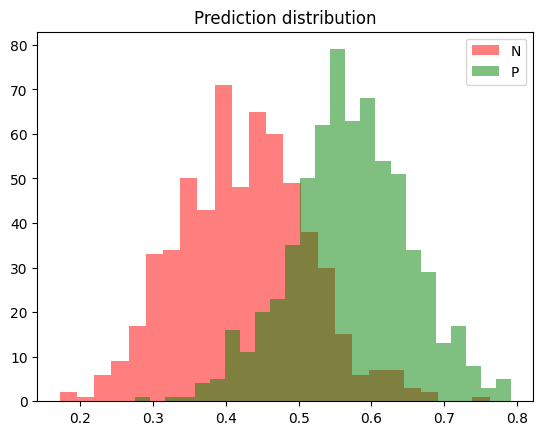

In [ ]:
# Plotting

plot_args = {"alpha": 0.5, "bins": 25, "density": False}
plt.hist(probas[y_test==0], label="N", color="r", **plot_args)
plt.hist(probas[y_test==1], label="P", color="g", **plot_args)
plt.title("Prediction distribution")
plt.legend()
plt.show()

#plt.savefig("drive/MyDrive/Skyline_ábra.png")

# Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html



```
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators = 20,
    verbose=0
)
```

Legyen adott $n$ db $D_i$ döntési fa, ezek predikcióját az $x\in X$ mintalemen jelölje $D_i(x) \in \{0,1\}$. Az $n$ fa aggregált predikciója ekkor az
$$ R(x) = \frac{1}{n}\sum_{i=1}^n D_i(x) $$
_ensemble_ (hibrid) modell. Ez lényegében (megfelelő normalizálás után) az $n$ fa többségi szavazása (azt az osztályt mondjuk, amelyikre több szavazat érkezett a fáktól)

Miért jó több modellt használni?
* megfelelő konstrukció mellett csökkenti a túltanulást, stabilizálja a kimenetet;
* sok _gyenge tanuló_ segítségével egy erős kimenetet kaphatunk.

Jelen esetben a gyenge tanulók a döntési fák, és az ensemble modell az ún. random forest. Ennek két ötlete van:
* több kis (sekély) fa használata a túltanulás elkerülése végett,
* randomitás bevezetése a stabilitás érdekében: minden fa minden vágásában a feature-ök (oszlopok) egy random ($f$ feature esetén általában $\sqrt{f}$ vagy $f/3$ darabot) halmazát látja csak.



# Hiperparaméter optimalizálás

[XKCD, 221](https://www.explainxkcd.com/wiki/index.php/221:_Random_Number): Random Number


Keressük az optimális hiperparaméter-kombinációt.

Módszer:
* Keresztvalidálás: választunk egy `score` paramétert, ezen metrika mentén értékeljük ki a hiperparaméter-kombinációkat (a validációs halmazon)
  * Teszt halmaz: a hiperparaméter optimalizálás után használjuk a modell végső kiértékelésére (nem vesz részt se a tanításban, se a hiperparaméter optimalizálásban)
  * Holdout módszer: a modellező halmazt felosztjuk
    * Validációs halmaz: a hiperparaméter optimalizálás során használjuk az adott hiperparaméter-kombináció kiértékelésére (de a tanításban nem vesz részt)
    * Tanító halmaz: a tanításra használjuk, minden hiperparaméter-kombinációt ezen próbálunk ki
  * KFold módszer: a modellező halmazt $k$ rétegre osztjuk, és minden hiperparaméter-kombinációt $k$-szor értékelünk ki (minden réteg pontosan egyszer lesz validációs halmaz)

* Hiperparaméter kereső paradigmák:
  * [Random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html): megadjuk a kipróbálandó hiperparaméterek egy _eloszlását_, és ezen eloszlásból sorsolunk $N$-szer, ahol $N$ az iterációk (kipróbált _random hiperparaméter-kombinációk_) száma
    * Előny: az iterációk számával szabályozható a tanítás hossza
    * Hátrány: kis iteráció esetén az eredmény nem feltétlen megbízható (kevés kombinációt láttunk)
  * [Grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html): megadjuk a hiperparaméterek konkrét értékeit, és ezen _rács_ mentén értékeljük ki a modellt (minden rácsponton)
    * Előny: _minden_ kombináció ki lesz próbálva, megbízható eredmény
    * Hátrány: nagy paramétert-tér esetén (ha túl nagy a kombinációk száma) a tanítás lassú

Megjegyzés: gyakran a kettőt együtt használják; grid search-ben megtaláljuk a hiperparaméterek optimális(nak tűnő) nagyságrendjét, és azon rácspont körül random search-csel keresünk egy modellt.



```
params = {
    "criterion": ["gini", "log_loss"],
    "max_depth": [3,4,5,6],
    "min_samples_split": loguniform(0.01,1.0),
    "max_samples": uniform(0.1, 0.9)
}

finder = RandomizedSearchCV(
    estimator = model,
    param_distributions=params,
    n_iter = 10,
    scoring="roc_auc",
    cv = [(train_idxs, validation_idxs)],
    random_state=42,
    verbose=3
)
```

_(Érdeklődőknek: léteznek természetesen más paradigmák is, érdemes megnézni pl. a Bayes-i keresést, amire az `optuna` könyvtár kiváló API-t szolgáltat.)_

Random keresés során, ha egy folytonos paraméter nagyságrendjét keressük, akkor [egyenletes](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html#scipy.stats.uniform) helyett [log-egyenletes](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.loguniform.html) eloszlást kell használni: ekkor az egyes nagyságrendek egyenlő mértékben lesznek kipróbálva:

0.01	0.333
0.1	0.654
1.0	1.0


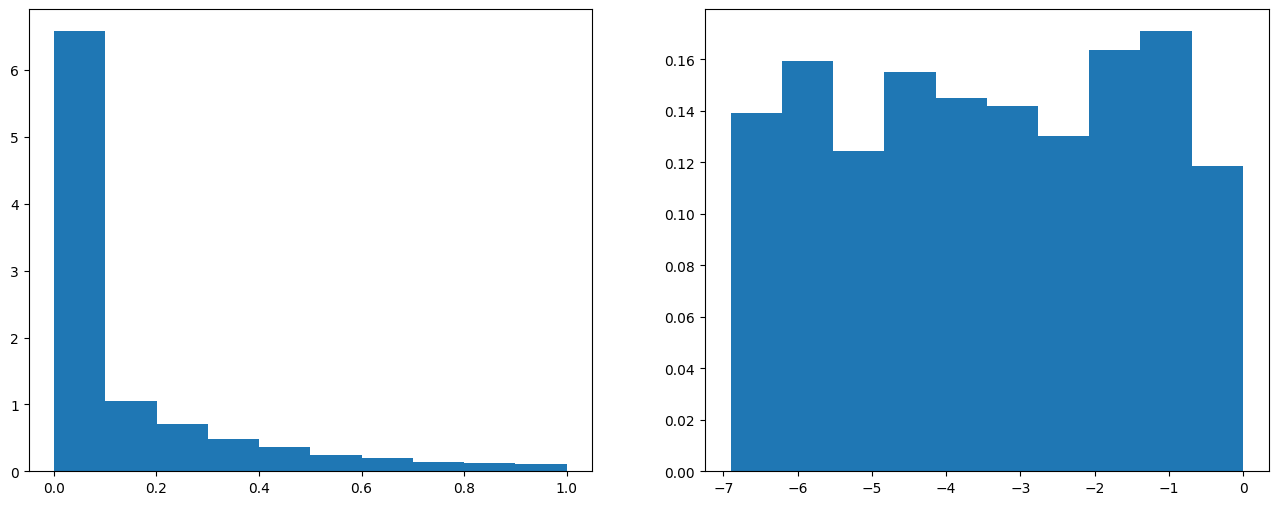

In [ ]:
dist = loguniform(0.001,1.0)
sample = dist.rvs(1000)

n = len(sample)
for i in [0.01,0.1,1.0]:
  print(i, sum(sample<i) / n, sep='\t')

fig, axs = plt.subplots(1,2, figsize=(16,6))
axs[0].hist(sample, density=True)
axs[1].hist(np.log(sample), density=True)
fig.show()

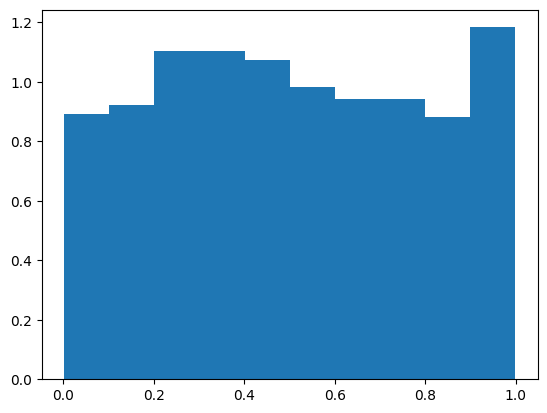

In [ ]:
u = uniform(0.001,1-0.001) #Így kell neki megmondani, hogy 0.001 és 1 között generáljon random számot
sample = u.rvs(1000)

plt.hist(sample, density=True)
plt.show()

# Teljesítmény mérés

[XKCD, 726:](https://xkcd.com/726/) Seat selection

Minden modell alapvetően az alábbi formába írható:
$$ f: X ↦ [0,1], $$
ahol $x\in X$ esetén $f(x)$ egy lehetséges (bár statisztikailag helytelen) értelmezése
$$ \mathbb{P}(x\in \text{pozitív osztály}) ≈ f(x), $$
vagyis $f(x)$ azt mondja meg, hogy az $x$ mintaelem milyen _valószínűséggel_ tartozik a pozitív osztályba. (Ez az $f(x)$ szokott lenni nálunk a `probas`.)

**Következmény:** minden tanítás végső soron egy threshold választási kérdéshez vezet, ahol a végső predikció $\alpha$ küszöbérték mellett
$$ x\in \text{pozitív osztály} ⇔ f(x)>\alpha. $$

Konkrétan:
```
preds = (probas>threshold).astype("int")
```

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix

In [ ]:
probas = best_model.predict_proba(X_test)
probas

array([[0.30293589, 0.69706411],
       [0.47315753, 0.52684247],
       [0.49311504, 0.50688496],
       ...,
       [0.6561421 , 0.3438579 ],
       [0.39694446, 0.60305554],
       [0.36457703, 0.63542297]])

In [ ]:
probas = probas[:,1] # a pozitív osztályhoz tartozó értékek (score-ok)

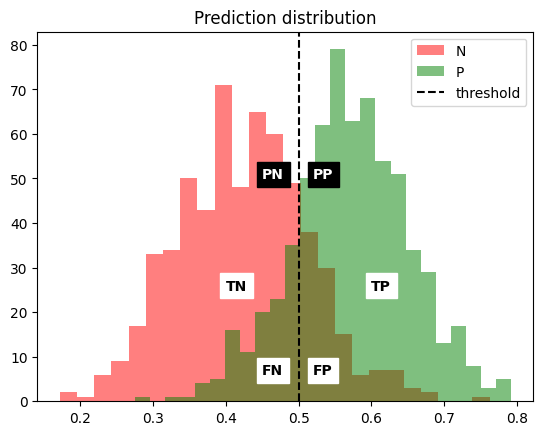

In [ ]:
plot_args = {"alpha": 0.5, "bins": 25, "density": False}

plt.hist(probas[y_test==0], label="N", color="r", **plot_args)
plt.hist(probas[y_test==1], label="P", color="g", **plot_args)

plt.axvline(0.5, color="black", linestyle="--", label="threshold")

plt.text(0.45,6, "FN", backgroundcolor="white", fontweight="bold")
plt.text(0.52,6, "FP", backgroundcolor="white", fontweight="bold")
plt.text(0.6,25, "TP", backgroundcolor="white", fontweight="bold")
plt.text(0.4,25, "TN", backgroundcolor="white", fontweight="bold")

plt.text(0.45,50, "PN", color="white", backgroundcolor="black", fontweight="bold")
plt.text(0.52,50, "PP", color="white", backgroundcolor="black", fontweight="bold")

plt.title("Prediction distribution")
plt.legend()
plt.show()

In [ ]:
preds = (probas>0.5).astype("int") # mi ennek a kódolásnak a neve?

In [ ]:
confusion_matrix(y_test, preds)

array([[482, 115],
       [105, 548]])

## ROC-AUC görbe

Emlékezzünk vissza a tévesztési mátrixra!

<center>

. | PN | PP |
--- | :---: | :---: |
N | TN | FP
P | FN | TP

</center>

A legfontosabb metrika, amelyik **független a threshold választásától** a ROC-AUC score. Ez az alábbi két metrikát használja:


* False positive rate: meg nem talált negatívok aránya $$ FPR = \frac{FP}{N} $$
* True positive rate (_recall_): megtalált pozitívok aránya $$ TPR = \frac{TP}{P} $$

Ha adott egy threshold, akkor a `probas`-ból tévesztési mátrixot lehet csinálni, és arra kiszámolni a fenti két metrikát. Minden 0 és 1 közötti thresholdra kiszámolva kapjuk a ROC-görbét:

* ROC görbe: $$ \text{threshold} \mapsto (FPR,TPR) $$
* ROC-AUC érték: a ROC-görbe alatti terület

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probas)

In [ ]:
pd.DataFrame().from_dict({
    "threshold": thresholds,
    "False positive rate": fpr,
    "True positive rate": tpr
}).sort_values(by="threshold")

,threshold,False positive rate,True positive rate
333,0.171854,1.000000,1.000000
332,0.274927,0.963149,1.000000
331,0.275534,0.963149,0.998469
330,0.324150,0.864322,0.998469
329,0.324322,0.864322,0.996937
...,...,...,...
4,0.688218,0.001675,0.071975
3,0.762551,0.001675,0.010720
2,0.763597,0.000000,0.010720
1,0.791746,0.000000,0.001531


In [ ]:
auc = roc_auc_score(y_test, probas)
auc

0.8917404788105919

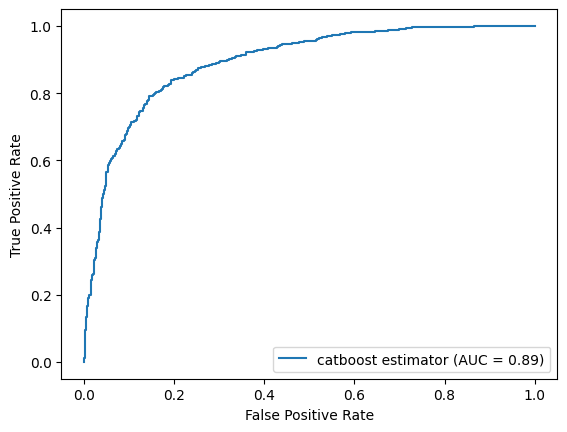

In [ ]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
                          estimator_name='catboost estimator')
display.plot()
plt.show()

#plt.savefig("drive/MyDrive/ROC_görbe.png")

In [ ]:
probas = best_model.predict_proba(X_test)
probas

array([[0.30293589, 0.69706411],
       [0.47315753, 0.52684247],
       [0.49311504, 0.50688496],
       ...,
       [0.6561421 , 0.3438579 ],
       [0.39694446, 0.60305554],
       [0.36457703, 0.63542297]])

In [ ]:
roc_auc_score(y_test, probas[:,0]), roc_auc_score(y_test, probas[:,1])

(0.10825952118940799, 0.8917404788105919)

## Threshold választás

<center>

. | PN | PP |
--- | :---: | :---: |
N | TN | FP
P | FN | TP

</center>

* Precision: a pozitívnak prediktált osztály ,,tisztasága'' $$ PREC = \frac{TP}{PP} $$
* Recall: megtalált pozitívok aránya $$ REC = \frac{TP}{P} $$

* F1 score: a _precision_ és _recall_ súlyozott harmonikus közepe $$ F_1 = 2\cdot \frac{PREC \cdot REC}{PREC + REC}$$


**Fő kérdés:** Hogyan válasszunk thresholdot?

Két természetes választás adódik.
* $P/N$ arányra: ha $P$ elem tartozik pozitív osztályba, $N$ a negatívba, akkor egy triviális modell $P/(P+N)$ valószínűséggel sorsol valakit a pozitív osztályba, $N/(P+N)$-nel a negatívba. Ekkor a természetes választás $P/N$.
* max F1 score: kiegyensúlyozza a precison és recall egymás elleni ,,harcát''

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
print("Class imbalance: ", y_test.sum() / len(y_test))

Class imbalance:  0.5224


In [ ]:
probas = best_model.predict_proba(X_test)[:,1]

In [ ]:
precs, recs, thresholds = precision_recall_curve(y_test, probas)

In [ ]:
thresholds = list(thresholds) + [1.0]

In [ ]:
pd.DataFrame().from_dict({
    "threshold": thresholds,
    "prec": precs,
    "rec": recs
}).sort_values(by="threshold")

,threshold,prec,rec
0,0.171854,0.522400,1.000000
1,0.194662,0.522818,1.000000
2,0.209045,0.523237,1.000000
3,0.221247,0.523657,1.000000
4,0.223881,0.524077,1.000000
...,...,...,...
1246,0.776422,1.000000,0.006126
1247,0.789721,1.000000,0.004594
1248,0.791007,1.000000,0.003063
1249,0.791746,1.000000,0.001531


In [ ]:
def harm_mean(a,b): #harm_mean: harmonikus közép
  return 2 * a * b / (a + b)

In [ ]:
f1s = []
for p,r in zip(precs, recs):
  f1s.append( harm_mean(p,r) )



```
f1s = list(map(lambda t: harm_mean(*t), zip(precs,recs)))
```



In [ ]:
max_idxs = np.argmax(f1s)
thresholds[max_idxs]

0.5001156441724672

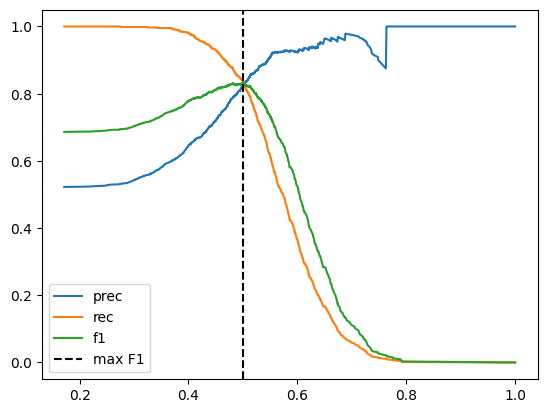

In [ ]:
plt.plot(thresholds, precs, label="prec")
plt.plot(thresholds, recs, label="rec")
plt.plot(thresholds, f1s, label="f1")

plt.axvline(thresholds[max_idxs], color="black", linestyle="--", label="max F1")

plt.legend()
plt.show()

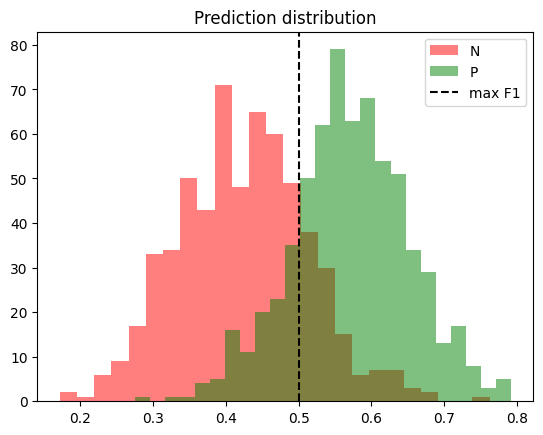

In [ ]:
plot_args = {"alpha": 0.5, "bins": 25, "density": False}

plt.hist(probas[y_test==0], label="N", color="r", **plot_args)
plt.hist(probas[y_test==1], label="P", color="g", **plot_args)
plt.axvline(thresholds[max_idxs], color="black", linestyle="--", label="max F1")

plt.title("Prediction distribution")
plt.legend()
plt.show()

# Gyakorlás

[XKCD, 1739](https://www.explainxkcd.com/wiki/index.php/1739:_Fixing_Problems): Fixing problems

## Metrikák

1. Hogyan változik a precision és a recall, ahogy a thresholdot 0-ról 1-re növeljük? Hova tennéd a thresholdot, ha a pozitív osztály félreklasszifikálása (FN) lenne a nagyobb baj (pl rákos betegek diagnosztizálása)?
1. Mekkora a precision és a recall, ha a threshold a két szélsőértékkel egyezik meg (azaz 0 vagy 1)? Hogyan függ ez össze a predikciók minimumával és maximumával? Milyen threshold értéktől kezdve nem változik ez a két mérőszám?
1. A fenti szélsőértékek esetén mennyi az F1 score értéke?

_Tökéletes modellnek_ nevezzük azt a klasszifikálót, amelyikre $f(x)=y(x)$ minden $x\in X$-re, azaz a modell kimenete _teljesen_ megegyezik a célváltozóéval.
1. Mennyi egy tökéletes modell precision és recall értéke? Mennyi az F1-score?
1. Mennyi egy tökéletes modell ROC-AUC-je?

Nevezzük _teljesen szeparáló modellenek_ (nem hivatalos elnevezés) azon modelleket, amelykre létezik olyan threshold, amelyikre nézve a modell _tökéletes_. Ez pontosan akkor teljesül, ha
$$\max\{f(x) | x\in N\} < \min\{ f(x) | x\in P\}. $$
Praktikusan ez azt jelenti, hogy a negatív osztály predikciói kisebbek a pozitív osztályra adott predikciókénál (a hisztogramon a két hupli elkülönül, szeparálható).
1. Mennyi egy teljesen szeparáló modell maximális F1-scoreja? Mennyi azon threshold mellett a precision és recall?
1. Eléri-e egy ilyen modell AUC-je az 1.0-et? Hogy néz majd ki nagyjából a ROC-görbe? Mit mondasz, az AUC ez alapján mit mér?



## Random Forrest

1. Illessz (hiperparaméter optimalizálás nélkül) egy [random forest modellt](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) az `X_modeling`-re, és értékeld ki az `X_test`-en ROC-AUC score-ral. Nézd meg, mi történik, ha a `verbose` értékét 1-re rakod! Melyik modell teljesítménye jobb: a (fent) hiperparaméter optimalizált, vagy a default értékekkel történt tanításé?
1. A [RandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)-t egészítsd ki a RandomForest lenti paramétereivel! Teljesítménymérésre használj 5-rétegű keresztvalidálást! Ennek beállítása egyszerű: `cv = [(train_idxs, validation_idxs)]` helyett `cv = 5`-at írj!  Paraméterek:
  * `min_impurity_decrease`: a lehetséges értékeket a [0.001,1.0] intervallumból sorsold ki! Milyen eloszlást használsz?
  * keresd ki, hogy melyik paraméter kontrollálja, hogy a fák az egyes vágások során a feature-ök hányadrészét látják, és a lehetséges értékeket tedd bele az optimalizálásba!

3. Illessz [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)-t a fenti modellre! Az értékek megadása a következőképp történhet (eloszlás helyett lista):
```
model = RandomForestClassifier(
    #inicializálás ...
)
params = {
    "criterion": ["gini", "log_loss"],
    "max_depth": [3,4,5,6],
    "min_samples_split": [0.01,0.1,1.0],
    "max_samples": [0.1,0.5,1.0],
    # saját hiperparaméter-listák ...
}
finder = RandomizedSearchCV(
    estimator = model,
    param_grid = params,
    scoring="roc_auc",
    cv = [(train_idxs, validation_idxs)],
    random_state=42,
    verbose=3
)
```
Hány paraméter kombinációt próbál majd ki a `finder` a `fit` parancs során? Hányat próbálna ki, ha 3-rétegű keresztvalidálást használnál? Milyen beállítási lehetőségeid vannak még? Nézz rá az API-ra és tanítsd be a modellt!



## Otthoni gyakorlás

Ha szeretnél még gyakorolni,
* válassz egy feladatot: klasszfikáció vagy regresszió,
* végy egy tetszőleges adathalmazt: `titanic.csv`, de a `sklearn.datasets` modul is a segítségedre lehet,
* válassz egy modellt a scikit-learn API-jából (figyelj, hogy a feladatnak megfelelő legyen),
* ha szükséges, ez alapján végezz adatelőfeldolgozást,
* válassz egy hiperparaméter optimalizálót, keresztvalidálást
* és taníts be egy modellt,
* végül az eredményeket írd ki!


Ha bármikor elakadsz: Tech Support Cheat Sheet ([XKCD, 627](https://xkcd.com/627/))



# Összefoglalás

Mikor gyakoroltál eleget?
* ha érted a különbséget a random és grid search között, és tudod használni a hozzájuk tartozó scikit-learn API-t;
* ha magabiztosan ki tudsz értékelni egy modellt a predikciója alapján;
* és ha érted a threshold választás lényegét.

# Házi feladat

Beküldési határidő:

- Első változat: április 13. 23:59:59
- Utolsó változat: április 20. 23:59:59

Beküldési útmutató:

- Mikor végeztél, mindig futtasd le az újra a kódod, hogy biztos nem maradt-e benne hiba (olyan kódot, ami nem fut le, sajnos nem tudunk elfogadni). Ezt a következőképp teheted meg:
1. Runtime / Restart and run all: újraindítja a sessiont, ha nincs bug a kódban, rendben lefut a végéig.
2. A kimenetekkel együtt töltsd le a notebookot `.ipynb` formátumban a gépedre.
3. A keletkezett `.ipnyb` fájlt töltsd fel a Teams megfelelő feladatához!

## Feladat

**Hiperparaméter keresés és threshold választás**

A házi feladat során **neurális hálóval** fogunk bináris klasszfikációt végezni. Vedd az órán is szereplő adathalmazt és keresztvalidációt:
```
X,y = make_classification(
    n_samples = 5000,
    n_features = 100,
    n_informative = 95,
    n_classes = 2
)

X = pd.DataFrame(X)
X_modeling, X_test, y_modeling, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

X_modeling = X_modeling.reset_index(drop=True)
train_idxs, validation_idxs = train_test_split(X_modeling.index, test_size=0.33, random_state=42)
```

Inicializáld az [MLPClassifiert](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) az alábbi módon:
* legfeljebb 100 iteráción keresztül frissítse a súlyokat,
* de legyen bekapcsolva az early_stopping (leállítja az adott tanulást, ha a validációs halmazon nem javul a teljesítmény valahány iteráción keresztül).

```
model = MLPClassifier(
    max_iter = ...,
    early_stopping = ...,
    verbose = ...
)
```

Végül végezz RandomSearch hiperparaméter optimalizálást az alábbi módon:
* keresztvalidálásnak a `train_idxs, validation_idxs`-eket használd (holdout módszer),
* a validációs halmazt ROC-AUC score-ral értékeld ki,
* és legalább 10 hiperparaméter-kombinációt próbálj ki.

```
finder = RandomizedSearchCV(
    ...
)
```

A hiperparaméter-térbe mindenképp kerüljenek be a következő paraméterek (a lehetséges értékeket nézd ki az API-ból):
* `learning_rate_init`:  learning rate értéke (figyelj az eloszlásra!),
* `solver`: súly optimalizáló függvény,
* `activation`: aktivációs réteg,
* `hidden_layer_sizes`: a háló szerkezetét az alábbi módon adhatod meg: ha `hidden_layer_sizes = (5,10,5)`, akkor _3 belső_ (rejtett) réteged lesz, amelyeknek dimenzói 5, 10 és 5. Próbálj ki legalább 3 hálószerkezetet!
* és még _legalább 1 szabadon választott_ hiperparaméter!

```
params = {
    "hidden_layer_sizes": # saját
    "learning_rate_init": # saját
    "solver": ...
    ...
}
```


Értékeld ki a tanítást a teszt halmazon:
* nézd meg a teszt AUC-t,
* és válaszd ki a thresholdot a maximális F1-score alapján!

Az eredményeid akár vizualizálhatod is.


In [ ]:
from sklearn.neural_network import MLPClassifier

X,y = make_classification(
    n_samples = 5000,
    n_features = 100,
    n_informative = 95,
    n_classes = 2
)

X = pd.DataFrame(X)
X_modeling, X_test, y_modeling, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

X_modeling = X_modeling.reset_index(drop=True)
train_idxs, validation_idxs = train_test_split(X_modeling.index, test_size=0.33, random_state=42)

In [ ]:
model = MLPClassifier(
    max_iter = 100,
    early_stopping = True,
    n_iter_no_change = 10, # Ha 10 iteráció után sincs javulás a validációs halmazon, akkor leáll
    verbose = 0
)

In [ ]:
dist = loguniform(0.001,1.0) # Ahogy órán néztük, hogy nem egyenletes, hanem log-egyenletes eloszlást kell venni
sample = dist.rvs(1000)

params = {
    "hidden_layer_sizes": [(5, 10, 5), (3, 5, 7), (10, 15, 20)], # Az egyik a feladatban szereplő hálószerkezet volt, a többit csak véletlenszerűen mondtam meg
    "learning_rate_init": sample,
    "solver": ['sgd', 'lbfgs', 'adam'], # Ezek a lehetséges solverek, próbálja ki mindet, és győzzön a legjobb
    "activation": ['logistic', 'tanh', 'relu', 'identity'], # Hasonlóan itt is
    "alpha": [0.001, 0.01, 0.1] # Ez lesz a szabadon választott hiperparaméter, és az értékeit most így állítottam be
}

In [ ]:
finder = RandomizedSearchCV(
    estimator = model,
    param_distributions = params,
    n_iter = 10,
    scoring="roc_auc",
    cv = [(train_idxs, validation_idxs)],
    random_state=42,
    verbose=0
)

finder.fit(X_modeling, y_modeling)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

RandomizedSearchCV(cv=[(Int64Index([ 994,  464, 3263, 2722, 3010, 2442, 1236, 3492, 3550,  212,
            ...
             466, 2169, 1638, 3092, 1095, 1130, 1294,  860, 3507, 3174],
           dtype='int64', length=2512),
                        Int64Index([2148, 1044, 3318,  439, 3515, 1849,   93, 1281, 3577, 1272,
            ...
            2860, 2474, 1258, 2984, 2273, 1702, 3657, 2015, 2715, 3150],
           dtype='int64', length=1238))],
                   estimator=MLPClassifier(early_stopping=True, ma...
       0.03873634, 0.08669337, 0.00135505, 0.06295368, 0.25762227,
       0.00214918, 0.04232948, 0.55421114, 0.05987395, 0.00395897,
       0.10342258, 0.16177121, 0.73186832, 0.69412571, 0.03143593,
       0.0618035 , 0.00243696, 0.00170492, 0.01528745, 0.19818859,
       0.00152715, 0.12813685, 0.00127264, 0.00903053, 0.46112452,
       0.01472779, 0.01131796, 0.00561483, 0.03850656, 0.00885521]),
                                        'solver': ['sgd', 'lbfgs', 'adam']},
                   random_state=42, scoring='roc_auc')

In [ ]:
# A modell kiértékelése, az órán látottak mintájára

best_model = finder.best_estimator_
print(f"Best params:\t\t\t{finder.best_params_}",
      f"Best score (validation):\t{finder.best_score_:.4f} AUC",
      sep='\n')

probas = best_model.predict_proba(X_test)[:,1]
print(f"ROC-AUC score (test):\t\t{roc_auc_score(y_test, probas):.4f} AUC")

Best params:			{'solver': 'lbfgs', 'learning_rate_init': 0.0017836536855058887, 'hidden_layer_sizes': (5, 10, 5), 'alpha': 0.001, 'activation': 'relu'}
Best score (validation):	0.9144 AUC
ROC-AUC score (test):		0.9394 AUC


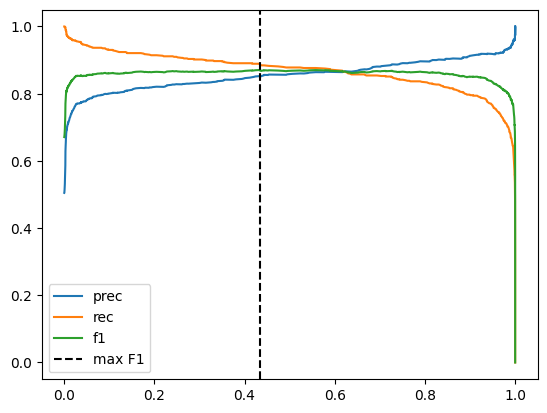

In [ ]:
# Eredmények vizualizálása

probas = best_model.predict_proba(X_test)[:,1]
precs, recs, thresholds = precision_recall_curve(y_test, probas)

thresholds = list(thresholds) + [1.0]

pd.DataFrame().from_dict({
    "threshold": thresholds,
    "prec": precs,
    "rec": recs
}).sort_values(by="threshold")

f1s = []
for p,r in zip(precs, recs):
  f1s.append( harm_mean(p,r) )

max_idxs = np.argmax(f1s)

plt.plot(thresholds, precs, label="prec")
plt.plot(thresholds, recs, label="rec")
plt.plot(thresholds, f1s, label="f1")

plt.axvline(thresholds[max_idxs], color="black", linestyle="--", label="max F1")

plt.legend()
plt.show()


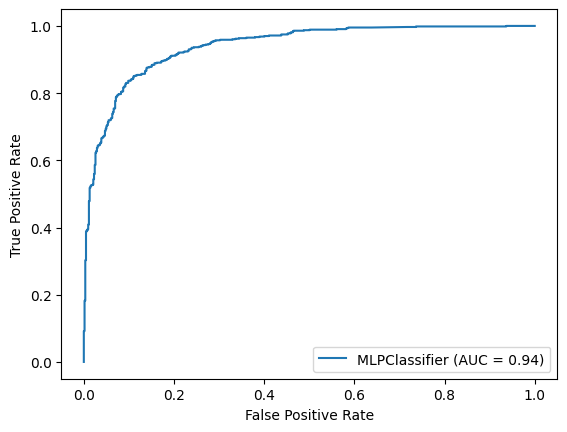

In [ ]:
# ROC görbe ábrázolása az óraiak mintájára

auc = roc_auc_score(y_test, probas)

fpr, tpr, thresholds = roc_curve(y_test, probas)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
                          estimator_name='MLPClassifier')
display.plot()
plt.show()
